In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("whitegrid")
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### 1.Prepare Dataset

In [2]:
df=pd.read_csv(r'C:\Users\aswat\Desktop\Great lakes\PROJECT\Indian-NSE-stock\nseComp.1.csv',parse_dates=['Date'],index_col='Date')

In [3]:
df=df.drop(['Unnamed: 0','Time'],axis=1)

In [4]:
df.head()

,Code,Open,High,Low,Close,Volume
Date,,,,,,
2015-07-03,3IINFOTECH,4.55,4.55,4.55,4.55,835.0
2015-07-03,3IINFOTECH,4.55,4.55,4.55,4.55,390.0
2015-07-03,3IINFOTECH,4.55,4.55,4.55,4.55,1000.0
2015-07-03,3IINFOTECH,4.55,4.55,4.55,4.55,1150.0
2015-07-03,3IINFOTECH,4.55,4.55,4.55,4.55,1100.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5803315 entries, 2015-07-03 to 2015-08-27
Data columns (total 6 columns):
Code      object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtypes: float64(5), object(1)
memory usage: 309.9+ MB


In [6]:
df['Code'].value_counts()

CADILAHC                           149424
BAJAJCORP                          135224
3IINFOTECH                          92412
AXISBANK                            78482
ASHOKLEY                            78465
BANKBARODA                          78461
BHEL                                78460
ASIANPAINT                          78457
BHARTIARTL                          78452
CANBK                               78449
ADANIPORTS                          78448
AUROPHARMA                          78446
BANKINDIA                           78441
BPCL                                78435
CAIRN                               78417
APOLLOTYRE                          78394
BHARATFORG                          78354
ARVIND                              78350
ABAN                                78346
ADANIENT                            78335
ALBK                                78267
AMBUJACEM                           78198
ADANIPOWER                          78171
CENTURYTEX                        

According to Business Insider, the top leading companies to invest in are:

    BAJAJCORP
    AXISBANK
    ASHOKLEY
    CANBK
    ADANIPOWER
    ANDHRABANK
    BIOCON
    AMBUJACEM
    BHEL
    ASIANPAINT
    
So we will do some analysis and prediction for these 10 companies.

In [7]:
df = df[df.Code.isin(['BAJAJCORP','AXISBANK','ASHOKLEY','CANBK','ADANIPOWER','ANDHRABANK','BIOCON','AMBUJACEM','BHEL','ASIANPAINT'])]

### 2.Data quality Assesment

In [8]:
df=df.dropna(axis=0)

In [9]:
# check if data set contains missing values
print(df.isnull().sum())

Code      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [10]:
df=df.drop_duplicates()

In [11]:
# check if data set contains duplicated records
print(df.duplicated().sum())

0


### 3.EDA and Feature Engineering

Check transaction volume for each companies we choose.

C:\Users\aswat\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



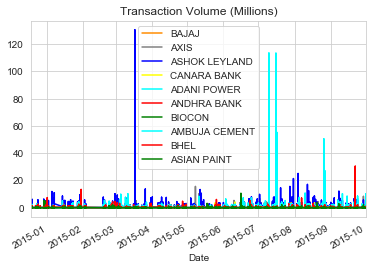

In [12]:
bajaj = df[df['Code']=='BAJAJCORP']
axis = df[df['Code']=='AXISBANK']
ashok = df[df['Code']=='ASHOKLEY']
canara = df[df['Code']=='CANBK']
adani = df[df['Code']=='ADANIPOWER']
andhra = df[df['Code']=='ANDHRABANK']
biocon =df[df['Code']=='BIOCON']
ambuja = df[df['Code']=='AMBUJACEM']
bhel = df[df['Code']=='BHEL']
asian = df[df['Code']=='ASIANPAINT']

# plot transaction volume
#plt.figure(figsize=(20,10))
(bajaj['Volume']/100000).plot(x='Date',color='darkorange', label='BAJAJ')
(axis['Volume']/100000).plot(x='Date',color='grey', label='AXIS')
(ashok['Volume']/100000).plot(x='Date',color='blue', label='ASHOK LEYLAND')
(canara['Volume']/100000).plot(x='Date',color='yellow', label='CANARA BANK')
(adani['Volume']/100000).plot(x='Date',color='cyan', label='ADANI POWER')
(andhra['Volume']/100000).plot(x='Date',color='red', label='ANDHRA BANK')
(biocon['Volume']/100000).plot(x='Date',color='green', label='BIOCON')
(ambuja['Volume']/100000).plot(x='Date',color='cyan', label='AMBUJA CEMENT')
(bhel['Volume']/100000).plot(x='Date',color='red', label='BHEL')
(asian['Volume']/100000).plot(x='Date',color='green', label='ASIAN PAINT')

plt.legend()
plt.xlabel('Date')
plt.title('Transaction Volume (Millions)')
plt.show()

As we can see from transaction volume plots:
1. As the transaction volume of Ambuja cement increased, the volume of the other companies also increased.
2. It seems like Ashok Leyland touches the peak after the closure of March financial year.
3. As per the plots the transaction occurs majorly between Jan to Oct in the year of 2015<br>

#### In order to keep our analysis more accurate with current trend, we will be focusing on year Jan to oct 2015.

In [13]:
df=df['2014-12-18':'2015-10-01']
#df=df.drop('Time',axis=1)

##### Price fluctuations

Check opening, closing, highest, and lowest price for each of the company.

In [14]:
df['oc_diff']=df['Close']-df['Open']
df.head()

,Code,Open,High,Low,Close,Volume,oc_diff
Date,,,,,,,
2015-07-03,ADANIPOWER,29.65,29.75,29.50,29.50,56257.0,-0.15
2015-07-03,ADANIPOWER,29.60,29.65,29.55,29.55,28837.0,-0.05
2015-07-03,ADANIPOWER,29.65,29.65,29.55,29.60,14447.0,-0.05
2015-07-03,ADANIPOWER,29.50,29.60,29.50,29.50,21076.0,0.00
2015-07-03,ADANIPOWER,29.55,29.60,29.50,29.55,27021.0,0.00


C:\Users\aswat\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



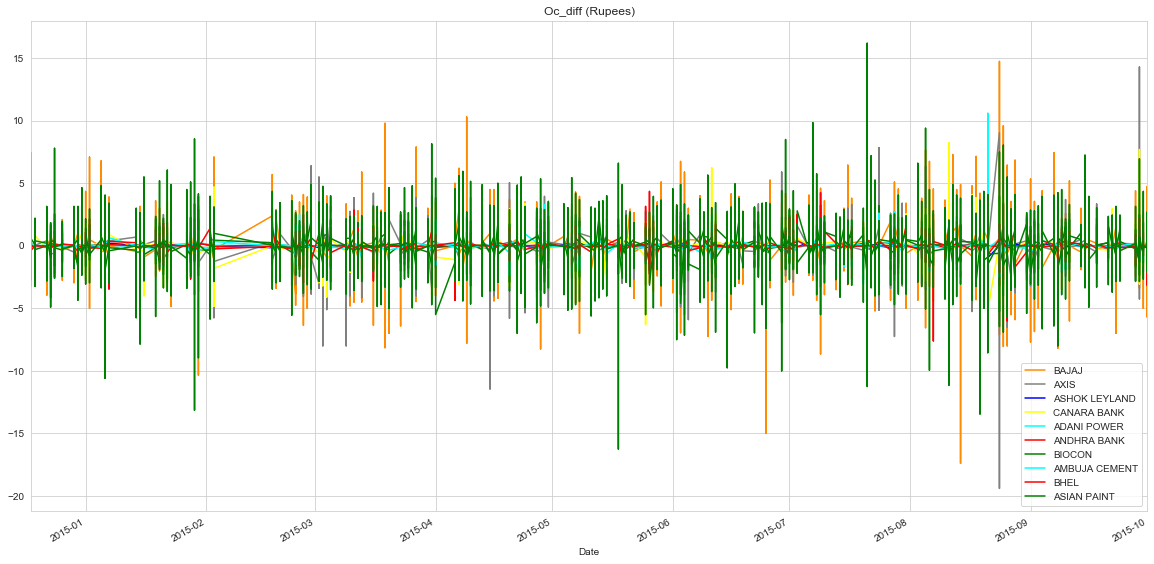

In [15]:
# Difference between opening and closing price
df['oc_diff']=df['Close']-df['Open']
bajaj = df[df['Code']=='BAJAJCORP']
axis = df[df['Code']=='AXISBANK']
ashok = df[df['Code']=='ASHOKLEY']
canara = df[df['Code']=='CANBK']
adani = df[df['Code']=='ADANIPOWER']
andhra = df[df['Code']=='ANDHRABANK']
biocon = df[df['Code']=='BIOCON']
ambuja = df[df['Code']=='AMBUJACEM']
bhel = df[df['Code']=='BHEL']
asian = df[df['Code']=='ASIANPAINT']

# plot transaction oc_diff
plt.figure(figsize=(20,10))
(bajaj['oc_diff']).plot(color='darkorange', label='BAJAJ')
(axis['oc_diff']).plot(color='grey', label='AXIS')
(ashok['oc_diff']).plot(color='blue', label='ASHOK LEYLAND')
(canara['oc_diff']).plot(color='yellow', label='CANARA BANK')
(adani['oc_diff']).plot(color='cyan', label='ADANI POWER')
(andhra['oc_diff']).plot(color='red', label='ANDHRA BANK')
(biocon['oc_diff']).plot(color='green', label='BIOCON')
(ambuja['oc_diff']).plot(color='cyan', label='AMBUJA CEMENT')
(bhel['oc_diff']).plot(color='red', label='BHEL')
(asian['oc_diff']).plot(color='green', label='ASIAN PAINT')

plt.legend()
plt.xlabel('Date')
plt.title('Oc_diff (Rupees)')
plt.show()

By plotting the difference between daily opening and closing price, we found that:
1. Daily opening price and closing price of Biocon and Bajaj cash varies the most, the differences can range from 15 to 10.
2. The rest of the companies that we selected tends to be fairly stable.

In [16]:
# Average difference for each companies
ave_diff={'bajaj':[(bajaj['oc_diff']).mean()],
'axis':[(axis['oc_diff']).mean()],
'ashok':[(ashok['oc_diff']).mean()],
'canara':[(canara['oc_diff']).mean()],
'adani':[(adani['oc_diff']).mean()],
'andhra':[(andhra['oc_diff']).mean()],
'biocon':[(biocon['oc_diff']).mean()],
'ambuja':[(ambuja['oc_diff']).mean()],
'bhel':[(bhel['oc_diff']).mean()],
'asian':[(asian['oc_diff']).mean()]}
pd.DataFrame(ave_diff, index=['avg.diff'])

,bajaj,axis,ashok,canara,adani,andhra,biocon,ambuja,bhel,asian
avg.diff,-0.017954,-0.005145,-0.000532,-0.002099,-0.001085,-0.001029,-0.004737,0.000989,0.000326,-0.011112


In [17]:
df['Spread']=abs(df['High']-df['Low'])
df.head()

,Code,Open,High,Low,Close,Volume,oc_diff,Spread
Date,,,,,,,,
2015-07-03,ADANIPOWER,29.65,29.75,29.50,29.50,56257.0,-0.15,0.25
2015-07-03,ADANIPOWER,29.60,29.65,29.55,29.55,28837.0,-0.05,0.10
2015-07-03,ADANIPOWER,29.65,29.65,29.55,29.60,14447.0,-0.05,0.10
2015-07-03,ADANIPOWER,29.50,29.60,29.50,29.50,21076.0,0.00,0.10
2015-07-03,ADANIPOWER,29.55,29.60,29.50,29.55,27021.0,0.00,0.10


C:\Users\aswat\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



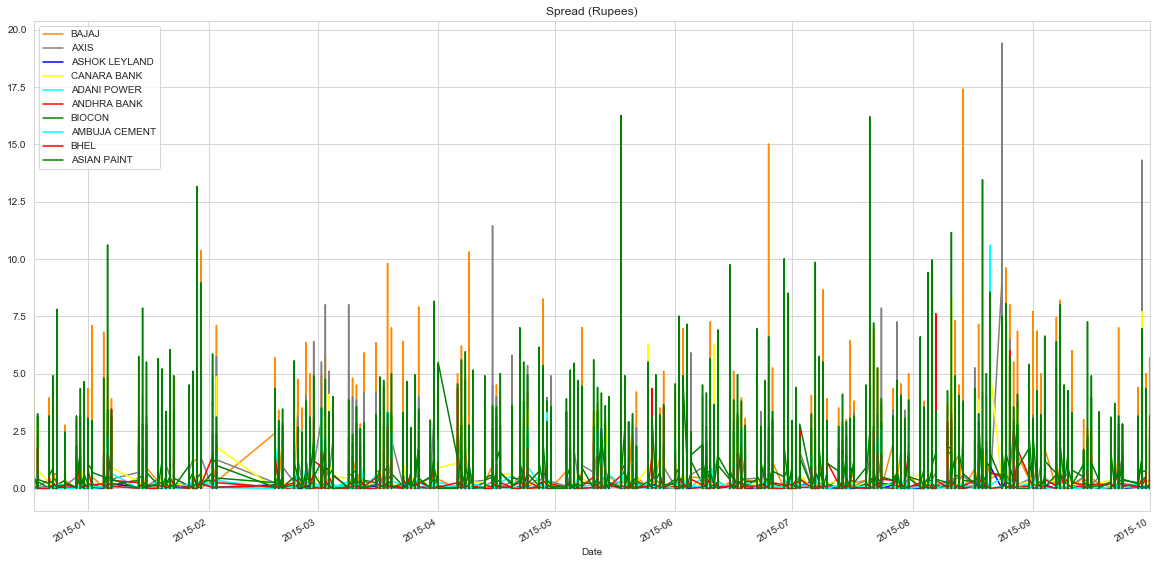

In [18]:
# Difference between high and low price
df['Spread']=abs(df['Close']-df['Open'])
bajaj = df[df['Code']=='BAJAJCORP']
axis = df[df['Code']=='AXISBANK']
ashok = df[df['Code']=='ASHOKLEY']
canara = df[df['Code']=='CANBK']
adani = df[df['Code']=='ADANIPOWER']
andhra = df[df['Code']=='ANDHRABANK']
biocon = df[df['Code']=='BIOCON']
ambuja = df[df['Code']=='AMBUJACEM']
bhel = df[df['Code']=='BHEL']
asian = df[df['Code']=='ASIANPAINT']

# plot transaction Spread
plt.figure(figsize=(20,10))
(bajaj['Spread']).plot(color='darkorange', label='BAJAJ')
(axis['Spread']).plot(color='grey', label='AXIS')
(ashok['Spread']).plot(color='blue', label='ASHOK LEYLAND')
(canara['Spread']).plot(color='yellow', label='CANARA BANK')
(adani['Spread']).plot(color='cyan', label='ADANI POWER')
(andhra['Spread']).plot(color='red', label='ANDHRA BANK')
(biocon['Spread']).plot(color='green', label='BIOCON')
(ambuja['Spread']).plot(color='cyan', label='AMBUJA CEMENT')
(bhel['Spread']).plot(color='red', label='BHEL')
(asian['Spread']).plot(color='green', label='ASIAN PAINT')

plt.legend()
plt.xlabel('Date')
plt.title('Spread (Rupees)')
plt.show()

In [19]:
# Average difference for each companies
ave_diff={'bajaj':[(bajaj['Spread']).mean()],
'axis':[(axis['Spread']).mean()],
'ashok':[(ashok['Spread']).mean()],
'canara':[(canara['Spread']).mean()],
'adani':[(adani['Spread']).mean()],
'andhra':[(andhra['Spread']).mean()],
'biocon':[(biocon['Spread']).mean()],
'ambuja':[(ambuja['Spread']).mean()],
'bhel':[(bhel['Spread']).mean()],
'asian':[(asian['Spread']).mean()]}
pd.DataFrame(ave_diff, index=['avg.diff'])

,bajaj,axis,ashok,canara,adani,andhra,biocon,ambuja,bhel,asian
avg.diff,0.363513,0.354345,0.058999,0.284822,0.041178,0.062978,0.316961,0.164433,0.196558,0.516751


To get a better understanding of difference between daily opening and closing price, we calculated the average difference as well as daily price spread for each company. Clearly, it also indicates bajaj,axis,biocon,asian has higher spread.

Although average of difference (closing - opening price) for ambuja and bhel is only has positive average, the average daily spread is 0.2 . It must be hard and nervous to watch the price flucuate that much.

#### Moving Averages and Price Trend<a id="3-3"></a>

A moving average (MA) is a widely used indicator in technical analysis that helps smooth out price action by filtering out the “noise” from random price fluctuations. It is a trend-following, or lagging, indicator because it is based on past prices.

#### Market Prices of companies<a id="3-4"></a>

C:\Users\aswat\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



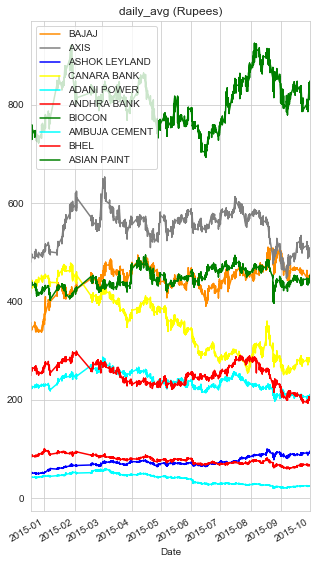

In [20]:
# calculate daily average price
df['daily_avg'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
bajaj = df[df['Code']=='BAJAJCORP']
axis = df[df['Code']=='AXISBANK']
ashok = df[df['Code']=='ASHOKLEY']
canara = df[df['Code']=='CANBK']
adani = df[df['Code']=='ADANIPOWER']
andhra = df[df['Code']=='ANDHRABANK']
biocon = df[df['Code']=='BIOCON']
ambuja = df[df['Code']=='AMBUJACEM']
bhel = df[df['Code']=='BHEL']
asian = df[df['Code']=='ASIANPAINT']

# plot transaction daily_avg
plt.figure(figsize=(5,10))
(bajaj['daily_avg']).plot(x='Date',color='darkorange', label='BAJAJ')
(axis['daily_avg']).plot(x='Date',color='grey', label='AXIS')
(ashok['daily_avg']).plot(x='Date',color='blue', label='ASHOK LEYLAND')
(canara['daily_avg']).plot(x='Date',color='yellow', label='CANARA BANK')
(adani['daily_avg']).plot(x='Date',color='cyan', label='ADANI POWER')
(andhra['daily_avg']).plot(x='Date',color='red', label='ANDHRA BANK')
(biocon['daily_avg']).plot(x='Date',color='green', label='BIOCON')
(ambuja['daily_avg']).plot(x='Date',color='cyan', label='AMBUJA CEMENT')
(bhel['daily_avg']).plot(x='Date',color='red', label='BHEL')
(asian['daily_avg']).plot(x='Date',color='green', label='ASIAN PAINT')

plt.legend()
plt.xlabel('Date')
plt.title('daily_avg (Rupees)')
plt.show()

#### Plot individual daily open, high, low, close prices

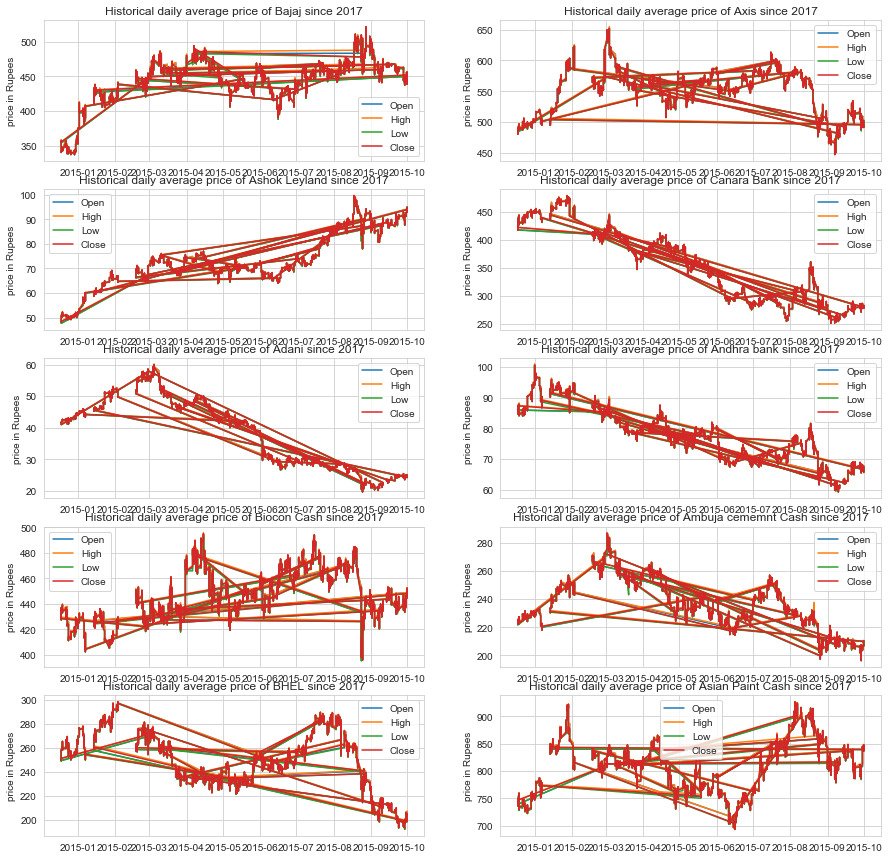

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(5,2,1)
plt.plot(bajaj[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Bajaj since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,2)
plt.plot(axis[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Axis since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,3)
plt.plot(ashok[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Ashok Leyland since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,4)
plt.plot(canara[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Canara Bank since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,5)
plt.plot(adani[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Adani since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,6)
plt.plot(andhra[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Andhra bank since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,7)
plt.plot(biocon[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Biocon Cash since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,8)
plt.plot(ambuja[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Ambuja cememnt Cash since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,9)
plt.plot(bhel[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of BHEL since 2017')
plt.legend(['Open','High','Low','Close'])

plt.subplot(5,2,10)
plt.plot(asian[['Open','High','Low','Close']])
plt.ylabel('price in Rupees')
plt.title('Historical daily average price of Asian Paint Cash since 2017')
plt.legend(['Open','High','Low','Close'])

plt.show()

### Return Ratio

return ratio = current value of the company / initial value of the company

In [22]:
df1=df.pivot_table(index=['Date','Code'],aggfunc='mean')

In [23]:
df1=df1.reset_index(level=0,drop=False)

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1830 entries, ADANIPOWER to CANBK
Data columns (total 9 columns):
Date         1830 non-null datetime64[ns]
Close        1830 non-null float64
High         1830 non-null float64
Low          1830 non-null float64
Open         1830 non-null float64
Spread       1830 non-null float64
Volume       1830 non-null float64
daily_avg    1830 non-null float64
oc_diff      1830 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 143.0+ KB


In [25]:
df1.head()

,Date,Close,High,Low,Open,Spread,Volume,daily_avg,oc_diff
Code,,,,,,,,,
ADANIPOWER,2014-12-18,41.367112,41.397594,41.331417,41.364973,0.032353,6754.866310,41.365274,0.002139
AMBUJACEM,2014-12-18,224.542513,224.686765,224.402941,224.533021,0.141578,4299.802139,224.541310,0.009492
ANDHRABANK,2014-12-18,86.329333,86.407067,86.252400,86.328800,0.080267,9144.650667,86.329400,0.000533
ASHOKLEY,2014-12-18,49.399600,49.450533,49.349867,49.394000,0.047200,54128.682667,49.398500,0.005600
ASIANPAINT,2014-12-18,743.661333,744.071200,743.225200,743.628267,0.456000,3002.602667,743.646500,0.033067


In [26]:
a=pd.DataFrame(df1.Date.unique())
a.shape

(183, 1)

In [27]:
bajaj = df1[df1.index=='BAJAJCORP']
axis = df1[df1.index=='AXISBANK']
ashok = df1[df1.index=='ASHOKLEY']
canara = df1[df1.index=='CANBK']
adani = df1[df1.index=='ADANIPOWER']
andhra = df1[df1.index=='ANDHRABANK']
biocon = df1[df1.index=='BIOCON']
ambuja = df1[df1.index=='AMBUJACEM']
bhel = df1[df1.index=='BHEL']
asian = df1[df1.index=='ASIANPAINT']


# Average difference for each companies
bajaj=np.array((bajaj['Close']).rolling(50).mean())
axis=np.array((axis['Close']).rolling(50).mean())
ashok=np.array((ashok['Close']).rolling(50).mean())
canara=np.array((canara['Close']).rolling(50).mean())
adani=np.array((adani['Close']).rolling(50).mean())
andhra=np.array((andhra['Close']).rolling(50).mean())
biocon=np.array((biocon['Close']).rolling(50).mean())
ambuja=np.array((ambuja['Close']).rolling(50).mean())
bhel=np.array((bhel['Close']).rolling(50).mean())
asian=np.array((asian['Close']).rolling(50).mean())

#Create data frame
bajaj=pd.DataFrame([bajaj]).T
axis=pd.DataFrame([axis]).T
ashok=pd.DataFrame([ashok]).T
canara=pd.DataFrame([canara]).T
adani=pd.DataFrame([adani]).T
andhra=pd.DataFrame([andhra]).T
biocon=pd.DataFrame([biocon]).T
ambuja=pd.DataFrame([ambuja]).T
bhel=pd.DataFrame([bhel]).T
asian=pd.DataFrame([asian]).T

close=pd.concat([a,bajaj,axis,ashok,canara,adani,andhra,biocon,ambuja,bhel,asian],join='outer',axis=1)
close.columns=['Date','bajaj','axis','ashok','canara','adani','andhra','biocon','ambuja','bhel','asian']
close_ma=close.set_index('Date')
close_ma=close_ma.tail(50)
close_ma.head()

,bajaj,axis,ashok,canara,adani,andhra,biocon,ambuja,bhel,asian
Date,,,,,,,,,,
2015-07-22,439.532834,569.381402,70.763053,311.054941,32.602846,72.678256,459.042295,233.966295,251.412527,771.748930
2015-07-23,440.032550,570.083873,71.002846,309.494191,32.354988,72.540332,459.548464,234.172757,252.567386,772.974169
2015-07-24,440.281955,570.525014,71.225022,307.857951,32.084353,72.353206,460.145579,234.334651,253.610719,774.110545
2015-07-27,440.281648,570.536644,71.440057,306.166479,31.793803,72.223746,460.461209,234.318337,254.500503,775.034671
2015-07-28,440.590846,570.378073,71.661484,304.377845,31.490388,72.070098,460.513456,234.180039,255.325687,776.513911


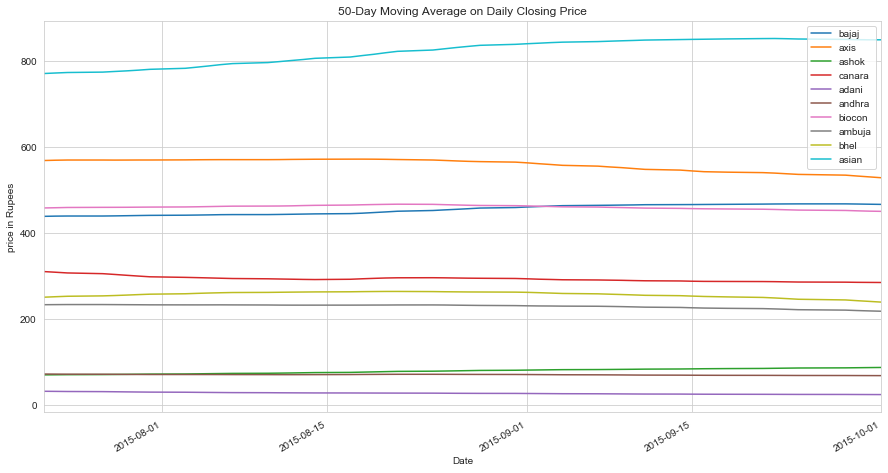

In [28]:
# plot moving average for closing price for cryptocurrencies
close_ma.plot(figsize=(15,8))
plt.title('50-Day Moving Average on Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('price in Rupees')
plt.show()

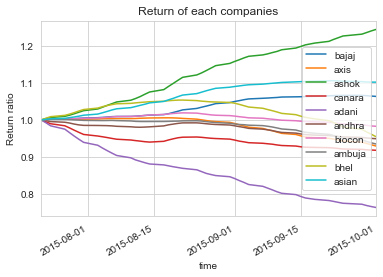

In [29]:
returns = close_ma.apply(lambda x: x/x[0])
returns.plot()
plt.ylabel('Return ratio')
plt.xlabel('time')
plt.title('Return of each companies')
plt.show()

#### Check Pearson correlation coefficient to prove if any companies price influences price of other companies

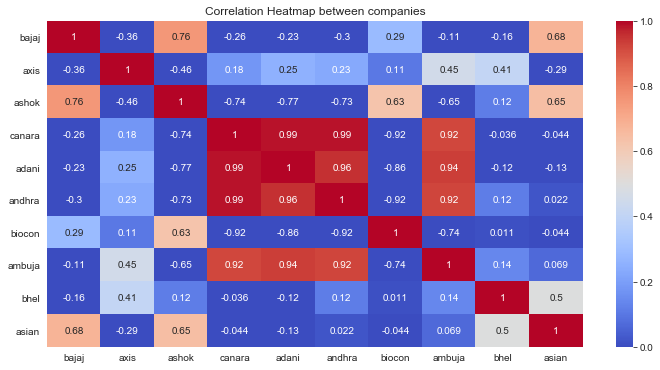

In [30]:
plt.figure(figsize=(12,6))
sns.heatmap(close.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between companies')
plt.show()

Based on the heatmap as well as some of the previous plots,

    1.we can say that Canara,Adani powers,Andhra Bank,Ambuja cement price does have strong positive impact to other companies. 
    2. As like ,Ashok leyland and Biocon has negative impact to other companies
    3. As the price of Canara bank,Adani power,Andhra Bank volume or price increased, the price of the other companies also increased.

#### Prepare data for models

I will separate the data set and build model on each companies type.

For data preparation, I will follow below steps:
1. move all 'daily_avg' values 30 lines up in our last cell(one month lag) and define a new column, 'daily_avg_After_Month'
2. choose 'daily_avg_After_Month' as target and all other variables as predictors
3. create train and test data by splitting the data set to 80-20
4. create 'X_forecast' using all predictors with NA 'daily_avg_After_Month' (to predict price in next 30 days)

In [31]:
df1.head()

,Date,Close,High,Low,Open,Spread,Volume,daily_avg,oc_diff
Code,,,,,,,,,
ADANIPOWER,2014-12-18,41.367112,41.397594,41.331417,41.364973,0.032353,6754.866310,41.365274,0.002139
AMBUJACEM,2014-12-18,224.542513,224.686765,224.402941,224.533021,0.141578,4299.802139,224.541310,0.009492
ANDHRABANK,2014-12-18,86.329333,86.407067,86.252400,86.328800,0.080267,9144.650667,86.329400,0.000533
ASHOKLEY,2014-12-18,49.399600,49.450533,49.349867,49.394000,0.047200,54128.682667,49.398500,0.005600
ASIANPAINT,2014-12-18,743.661333,744.071200,743.225200,743.628267,0.456000,3002.602667,743.646500,0.033067


In [32]:
mask=(df.index>'2015-08-01')
df=df.loc[mask]

In [33]:
from sklearn.preprocessing import LabelEncoder
l=LabelEncoder()
df['Code']=l.fit_transform(df['Code'])

In [34]:
df.Code.value_counts()

5    15527
3    15517
7    15513
9    15510
4    15510
1    15491
2    15435
0    15414
8    15145
6    11802
Name: Code, dtype: int64

In [35]:
bajaj = df[df.Code==0]
axis = df[df.Code==1]
ashok = df[df.Code==2]
canara = df[df.Code==3]
adani = df[df.Code==4]
andhra = df[df.Code==5]
biocon = df[df.Code==6]
ambuja = df[df.Code==7]
bhel = df[df.Code==8]
asian = df[df.Code==9]

# 0 (A)
A = df[df.Code == 0].copy()
A['daily_avg_After_Month']=A['daily_avg'].shift(-60)
y_A = A.dropna()['daily_avg_After_Month']
X_A = A.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.3,train_size=.7,random_state=42)
X_forecast_A =  A.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 1 (B)
B = df[df.Code == 1].copy()
B['daily_avg_After_Month']=B['daily_avg'].shift(-60)
y_B = B.dropna()['daily_avg_After_Month']
X_B = B.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.3,train_size=.7,random_state=42)
X_forecast_B =  B.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 2 (C)
C = df[df.Code == 2].copy()
C['daily_avg_After_Month']=C['daily_avg'].shift(-60)
y_C = C.dropna()['daily_avg_After_Month']
X_C = C.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.3,train_size=.7,random_state=42)
X_forecast_C =  C.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 3 (D)
D = df[df.Code == 3].copy()
D['daily_avg_After_Month']=D['daily_avg'].shift(-60)
y_D = D.dropna()['daily_avg_After_Month']
X_D = D.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D, test_size=0.3,train_size=.7,random_state=42)
X_forecast_D =  D.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 4 (E)
E = df[df.Code == 4].copy()
E['daily_avg_After_Month']=E['daily_avg'].shift(-60)
y_E = E.dropna()['daily_avg_After_Month']
X_E = E.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X_E, y_E, test_size=0.3,train_size=.7,random_state=42)
X_forecast_E =  E.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 6 (F)
F = df[df.Code == 6].copy()
F['daily_avg_After_Month']=F['daily_avg'].shift(-60)
y_F = F.dropna()['daily_avg_After_Month']
X_F = F.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_F, y_F, test_size=0.3,train_size=.7,random_state=42)
X_forecast_F =  F.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 7 (G)
G = df[df.Code == 7].copy()
G['daily_avg_After_Month']=G['daily_avg'].shift(-60)
y_G = G.dropna()['daily_avg_After_Month']
X_G = G.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_G, X_test_G, y_train_G, y_test_G = train_test_split(X_G, y_G, test_size=0.3,train_size=.7,random_state=42)
X_forecast_G =  G.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 8 (H)
H = df[df.Code == 8].copy()
H['daily_avg_After_Month']=H['daily_avg'].shift(-60)
y_H = H.dropna()['daily_avg_After_Month']
X_H = H.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(X_H, y_H, test_size=0.3,train_size=.7,random_state=42)
X_forecast_H =  H.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 9 (I)
I = df[df.Code == 9].copy()
I['daily_avg_After_Month']=I['daily_avg'].shift(-60)
y_I = I.dropna()['daily_avg_After_Month']
X_I = I.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_I, X_test_I, y_train_I, y_test_I = train_test_split(X_I, y_I, test_size=0.3,train_size=.7,random_state=42)
X_forecast_I =  I.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

# 5 (J)
J = df[df.Code == 5].copy()
J['daily_avg_After_Month']=J['daily_avg'].shift(-60)
y_J = J.dropna()['daily_avg_After_Month']
X_J = J.dropna().drop(['daily_avg_After_Month','daily_avg'], axis=1)
X_train_J, X_test_J, y_train_J, y_test_J = train_test_split(X_J, y_J, test_size=0.3,train_size=.7,random_state=42)
X_forecast_J =  J.tail(60).drop(['daily_avg_After_Month','daily_avg'], axis=1)

#### Applying machine learning methods

In [36]:
# define regression function
def regression(X_train, X_test, y_train, y_test):
    Regressor = {
        'Random Forest Regressor': RandomForestRegressor(n_estimators=200),
        'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=200),
        'ExtraTrees Regressor': ExtraTreesRegressor(n_estimators=200, min_samples_split=5),
        'Bayesian Ridge': BayesianRidge(),
        'Elastic Net CV': ElasticNetCV()
    }

    for name, clf in Regressor.items():
        print(name)
        clf.fit(X_train, y_train)
    
        print(f'R2: {r2_score(y_test, clf.predict(X_test)):.2f}')
        print(f'MAE: {mean_absolute_error(y_test, clf.predict(X_test)):.2f}')
        print(f'MSE: {mean_squared_error(y_test, clf.predict(X_test)):.2f}')
        print()

In [37]:
print('BAJAJCORP:')
regression(X_train_A, X_test_A, y_train_A, y_test_A)

BAJAJCORP:
Random Forest Regressor
R2: 0.95
MAE: 0.28
MSE: 0.32

Gradient Boosting Regressor
R2: 0.95
MAE: 0.27
MSE: 0.29

ExtraTrees Regressor
R2: 0.94
MAE: 0.29
MSE: 0.34

Bayesian Ridge
R2: 0.95
MAE: 0.27
MSE: 0.32

Elastic Net CV
R2: 0.42
MAE: 1.58
MSE: 3.49



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [38]:
print('AXISBK:')
regression(X_train_B, X_test_B, y_train_B, y_test_B)

AXISBK:
Random Forest Regressor
R2: 0.93
MAE: 1.38
MSE: 6.02

Gradient Boosting Regressor
R2: 0.93
MAE: 1.43
MSE: 5.98

ExtraTrees Regressor
R2: 0.93
MAE: 1.40
MSE: 6.10

Bayesian Ridge
R2: 0.91
MAE: 1.50
MSE: 8.18

Elastic Net CV
R2: 0.80


C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



MAE: 3.59
MSE: 18.39



In [39]:
print('ASHOKLEY:')
regression(X_train_C, X_test_C, y_train_C, y_test_C)

ASHOKLEY:
Random Forest Regressor
R2: 0.96
MAE: 0.61
MSE: 1.24

Gradient Boosting Regressor
R2: 0.96
MAE: 0.59
MSE: 1.12

ExtraTrees Regressor
R2: 0.96
MAE: 0.63
MSE: 1.34

Bayesian Ridge
R2: 0.96
MAE: 0.59
MSE: 1.26

Elastic Net CV
R2: 0.96
MAE: 0.63
MSE: 1.29



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [40]:
print('CANBK:')
regression(X_train_D, X_test_D, y_train_D, y_test_D)

CANBK:
Random Forest Regressor
R2: 0.91
MAE: 0.71
MSE: 1.11

Gradient Boosting Regressor
R2: 0.91
MAE: 0.70
MSE: 1.09

ExtraTrees Regressor
R2: 0.91
MAE: 0.73
MSE: 1.17

Bayesian Ridge
R2: 0.90
MAE: 0.74
MSE: 1.28

Elastic Net CV
R2: 0.00
MAE: 2.70
MSE: 12.21



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [41]:
print('ADANIPOWER:')
regression(X_train_E, X_test_E, y_train_E, y_test_E)

ADANIPOWER:
Random Forest Regressor
R2: 0.97
MAE: 4.80
MSE: 47.64

Gradient Boosting Regressor
R2: 0.97
MAE: 4.74
MSE: 46.76

ExtraTrees Regressor
R2: 0.97
MAE: 4.82
MSE: 48.57

Bayesian Ridge
R2: 0.97
MAE: 4.96
MSE: 52.22

Elastic Net CV
R2: 0.97
MAE: 4.97
MSE: 52.30



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3162.0814065758605, tolerance: 1641.088279427092



In [42]:
print('BIOCON:')
regression(X_train_F, X_test_F, y_train_F, y_test_F)

BIOCON:
Random Forest Regressor
R2: 0.91
MAE: 3.70
MSE: 29.48

Gradient Boosting Regressor
R2: 0.91
MAE: 3.62
MSE: 28.61

ExtraTrees Regressor
R2: 0.91
MAE: 3.71
MSE: 29.72

Bayesian Ridge
R2: 0.90
MAE: 3.87
MSE: 33.74

Elastic Net CV
R2: 0.90
MAE: 3.89
MSE: 33.76



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [43]:
print('AMBUJACEM:')
regression(X_train_G, X_test_G, y_train_G, y_test_G)

AMBUJACEM:
Random Forest Regressor
R2: 0.97
MAE: 2.08
MSE: 23.04

Gradient Boosting Regressor
R2: 0.97
MAE: 2.22
MSE: 22.73

ExtraTrees Regressor
R2: 0.97
MAE: 2.09
MSE: 22.73

Bayesian Ridge
R2: 0.97
MAE: 2.24
MSE: 27.79

Elastic Net CV
R2: 0.96
MAE: 2.77
MSE: 29.47



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [44]:
print('BHEL:')
regression(X_train_H, X_test_H, y_train_H, y_test_H)

BHEL:
Random Forest Regressor
R2: 0.94
MAE: 2.71
MSE: 19.14

Gradient Boosting Regressor
R2: 0.94
MAE: 2.59
MSE: 17.56

ExtraTrees Regressor
R2: 0.94
MAE: 2.72
MSE: 19.17

Bayesian Ridge
R2: 0.93
MAE: 2.69
MSE: 19.69

Elastic Net CV
R2: 0.93
MAE: 2.70
MSE: 19.75



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [45]:
print('ASIAN PAINT:')
regression(X_train_I, X_test_I, y_train_I, y_test_I)

ASIAN PAINT:
Random Forest Regressor
R2: 0.97
MAE: 2.72
MSE: 15.39

Gradient Boosting Regressor
R2: 0.97
MAE: 2.72
MSE: 15.11

ExtraTrees Regressor
R2: 0.97
MAE: 2.74
MSE: 15.63

Bayesian Ridge
R2: 0.97
MAE: 2.88
MSE: 17.74

Elastic Net CV
R2: 0.94
MAE: 4.46
MSE: 33.01



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [46]:
print('ANDHRABK:')
regression(X_train_J, X_test_J, y_train_J, y_test_J)

ANDHRABK:
Random Forest Regressor
R2: 0.96
MAE: 3.81
MSE: 57.18

Gradient Boosting Regressor
R2: 0.96
MAE: 3.84
MSE: 55.04

ExtraTrees Regressor
R2: 0.96
MAE: 3.85
MSE: 57.99

Bayesian Ridge
R2: 0.96
MAE: 3.85
MSE: 62.37

Elastic Net CV
R2: 0.91
MAE: 9.18
MSE: 135.01



C:\Users\aswat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [47]:
df.index.max(),df.index.min()

(Timestamp('2015-10-01 00:00:00'), Timestamp('2015-08-03 00:00:00'))

#### Prices prediction

In [48]:
# define prediction function
def prediction(Code, X, y, X_forecast):
    if Code in [0,1,2,3,4,5,6,7,8,9]:
        model = ExtraTreesRegressor(n_estimators=200)
    model.fit(X, y)
    target = model.predict(X_forecast)
    return target

In [49]:
# calculate forecasted prices for next 30 days
forecasted_A = prediction(0, X_A, y_A, X_forecast_A)
forecasted_B = prediction(1, X_B, y_B, X_forecast_B)
forecasted_C = prediction(2, X_C, y_C, X_forecast_C)
forecasted_D = prediction(3, X_D, y_D, X_forecast_D)
forecasted_E = prediction(4, X_E, y_E, X_forecast_E)
forecasted_F = prediction(6, X_F, y_F, X_forecast_F)
forecasted_G = prediction(7, X_G, y_G, X_forecast_G)
forecasted_H = prediction(8, X_H, y_H, X_forecast_H)
forecasted_I = prediction(9, X_I, y_I, X_forecast_I)
forecasted_J = prediction(5, X_J, y_J, X_forecast_J)

In [50]:
len(forecasted_A)

60

In [51]:
# define Code for next 60 days
last_date=df1.iloc[-1].Date
modified_date1 =( last_date + dt.timedelta(days=1))
modified_date =( modified_date1 + dt.timedelta(days=1))
new_date = pd.date_range(modified_date,periods=60,freq='D')

# assign pd.dfFrame to newly defined Code
forecasted_0 = pd.DataFrame(forecasted_A, columns=['daily_avg'], index=new_date)
forecasted_1 = pd.DataFrame(forecasted_B, columns=['daily_avg'], index=new_date)
forecasted_2 = pd.DataFrame(forecasted_C, columns=['daily_avg'], index=new_date)
forecasted_3 = pd.DataFrame(forecasted_D, columns=['daily_avg'], index=new_date)
forecasted_4 = pd.DataFrame(forecasted_E, columns=['daily_avg'], index=new_date)
forecasted_6 = pd.DataFrame(forecasted_F, columns=['daily_avg'], index=new_date)
forecasted_7 = pd.DataFrame(forecasted_G, columns=['daily_avg'], index=new_date)
forecasted_8 = pd.DataFrame(forecasted_H, columns=['daily_avg'], index=new_date)
forecasted_9 = pd.DataFrame(forecasted_I, columns=['daily_avg'], index=new_date)
forecasted_5 = pd.DataFrame(forecasted_J, columns=['daily_avg'], index=new_date)



# combine historical price and predicted price
A = pd.concat([df[df.Code==0][['daily_avg']], forecasted_0])
B = pd.concat([df[df.Code==1][['daily_avg']], forecasted_1])
C = pd.concat([df[df.Code==2][['daily_avg']], forecasted_2])
D = pd.concat([df[df.Code==3][['daily_avg']], forecasted_3])
E = pd.concat([df[df.Code==4][['daily_avg']], forecasted_4])
F = pd.concat([df[df.Code==6][['daily_avg']], forecasted_6])
G = pd.concat([df[df.Code==7][['daily_avg']], forecasted_7])
H = pd.concat([df[df.Code==8][['daily_avg']], forecasted_8])
I = pd.concat([df[df.Code==9][['daily_avg']], forecasted_9])
J = pd.concat([df[df.Code==5][['daily_avg']], forecasted_5])

#### Bajaj Corp

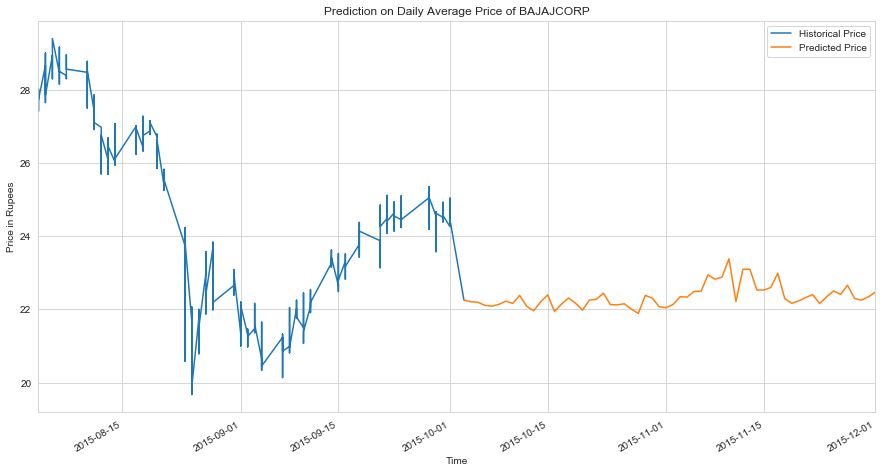

In [52]:
plt.figure(figsize=(15,8))
(A[:-59]['daily_avg']).plot(label='Historical Price')
(A[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of BAJAJCORP')
plt.legend()
plt.show()

#### Axis Bank

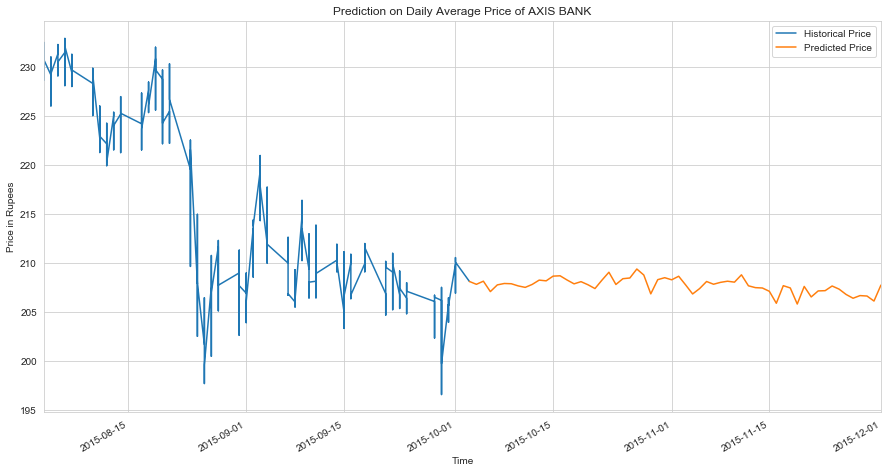

In [53]:
plt.figure(figsize=(15,8))
(B[:-59]['daily_avg']).plot(label='Historical Price')
(B[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of AXIS BANK')
plt.legend()
plt.show()

#### Ashok Leyland

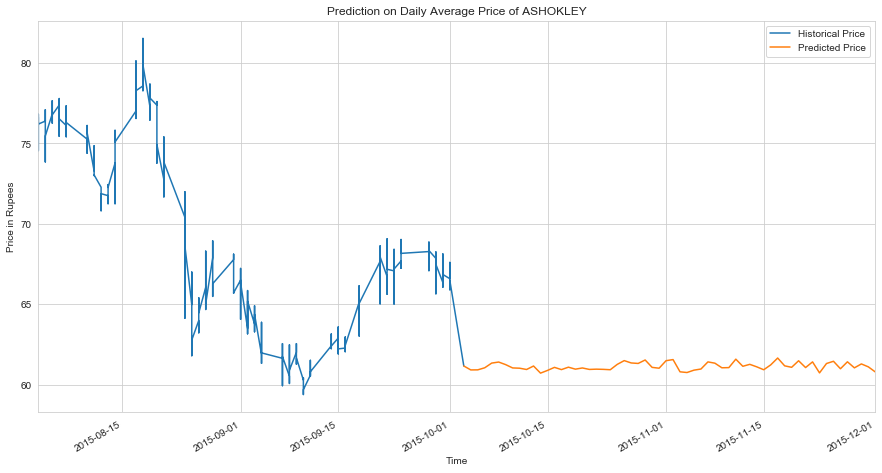

In [54]:
plt.figure(figsize=(15,8))
(C[:-59]['daily_avg']).plot(label='Historical Price')
(C[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of ASHOKLEY')
plt.legend()
plt.show()

#### Canara Bank

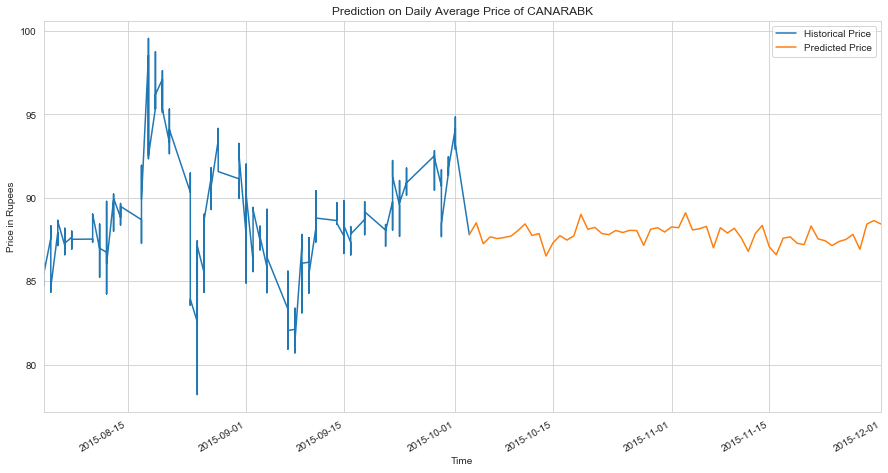

In [55]:
plt.figure(figsize=(15,8))
(D[:-59]['daily_avg']).plot(label='Historical Price')
(D[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of CANARABK')
plt.legend()
plt.show()

#### Adani Power

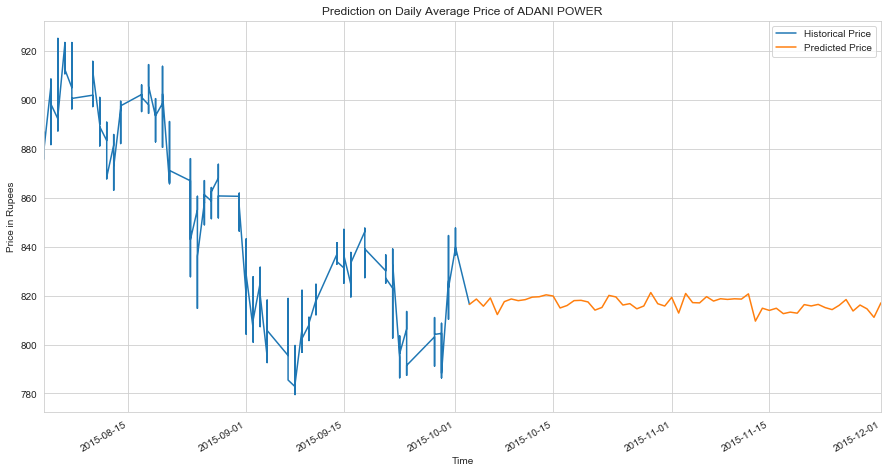

In [56]:
plt.figure(figsize=(15,8))
(E[:-59]['daily_avg']).plot(label='Historical Price')
(E[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of ADANI POWER')
plt.legend()
plt.show()

#### BIOCON

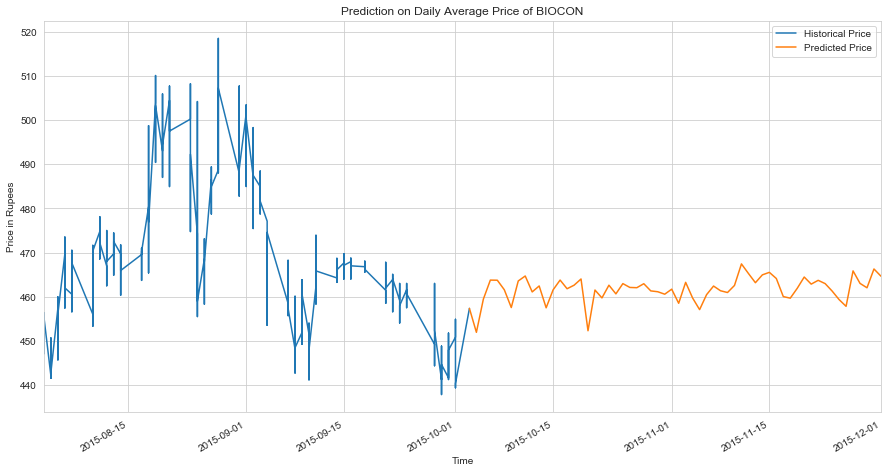

In [57]:
plt.figure(figsize=(15,8))
(F[:-59]['daily_avg']).plot(label='Historical Price')
(F[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of BIOCON')
plt.legend()
plt.show()

#### Ambuja Cement

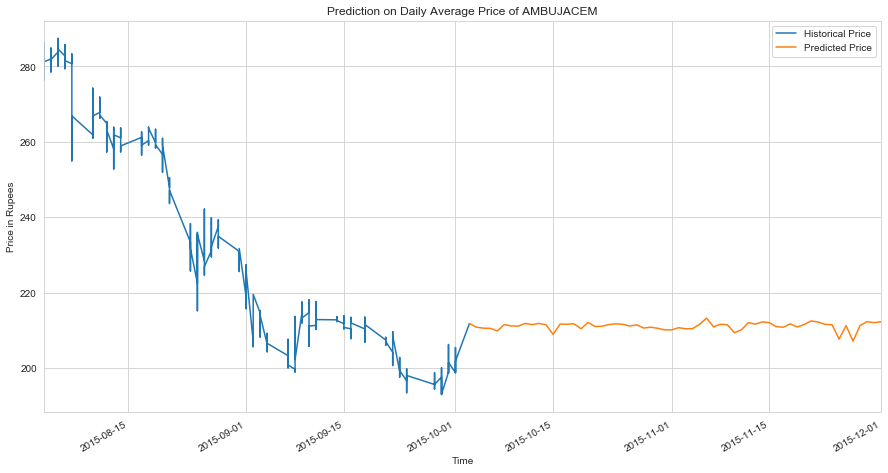

In [58]:
plt.figure(figsize=(15,8))
(G[:-59]['daily_avg']).plot(label='Historical Price')
(G[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of AMBUJACEM')
plt.legend()
plt.show()

#### BHEL

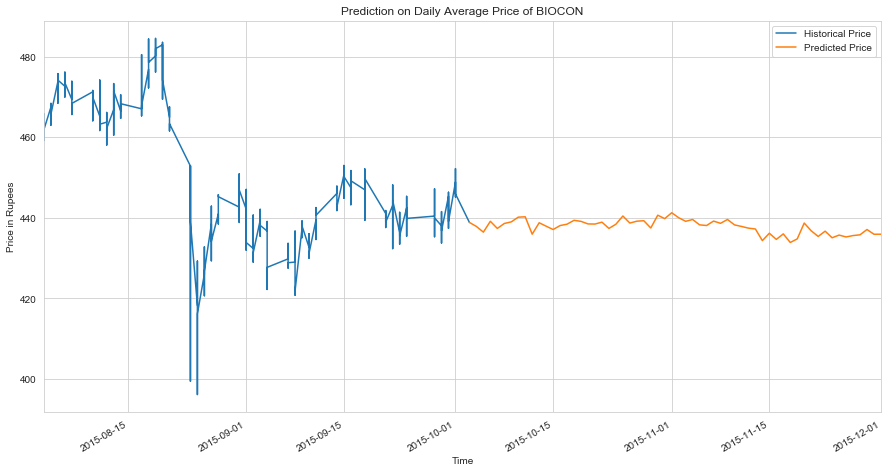

In [59]:
plt.figure(figsize=(15,8))
(H[:-59]['daily_avg']).plot(label='Historical Price')
(H[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of BIOCON')
plt.legend()
plt.show()

#### Asian Paint

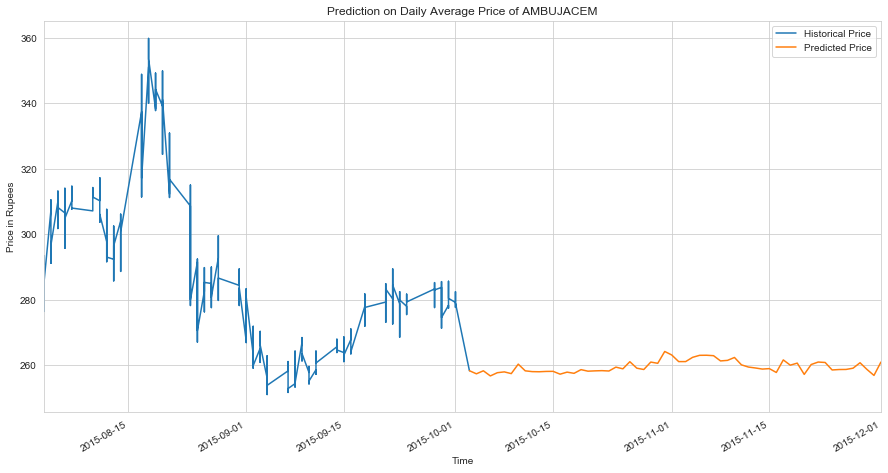

In [60]:
plt.figure(figsize=(15,8))
(I[:-59]['daily_avg']).plot(label='Historical Price')
(I[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of AMBUJACEM')
plt.legend()
plt.show()

#### Andhra Bank

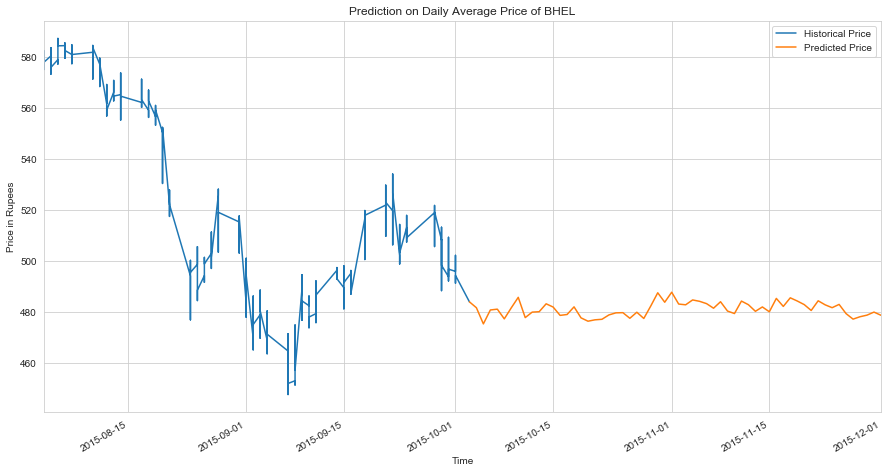

In [61]:
plt.figure(figsize=(15,8))
(J[:-59]['daily_avg']).plot(label='Historical Price')
(J[-60:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in Rupees')
plt.title('Prediction on Daily Average Price of BHEL')
plt.legend()
plt.show()

### 5. Conclusion - Investment Suggestion<a id="5"></a>

##### How to maximize your short term investment gains?<a id="5-1"></a>


**10% to 25% in AMBUJACEM and BIOCON.** BIOCON and AMBUJACEM are the leading companies in the markets often mirror their performance. These companies represent a solid foundation to any portfolio but will be outperformed in the long to medium term. As a result, limit your investments in these coins.

**25% to 55% in stock market**, in contrast to companies which A 10% drop in prices over the course of 24 hours is no longer as alarming as it used to be, stock market is as a safer place comparably where drastic fall in price is less likely to happen.

**25% to 55% in savings and Funds**, the safest place to put money is still in the bank. Depending on the risk awareness of an investor, it's advised to put 25% to 55% of their investment to bank or investment funds.

**10% to 15% in swing trading and/or day trading**, the more volatile companies such as BAJAJCORP and AXISBANK and BIOCON which record high daily trade volumes are good options for both swing and day trading. Traders should seek to benefit from price fluctuations and should utilize the leverage trading options provided by some of the top exchanges. More experienced traders should make use of shorting orders to also benefit from drops in price.


##### Whether to invest in cryptocurrency in the long term?<a id="5-2"></a>

Companies has several unique characteristics, for example, purchases are not taxed, no third-party interruptions, user anonymity, and its merit in asset division of divorcement. 

Besides, none of the events happened recently warrants a review of long-term price forecast, which takes root in the currency's fundamentals. Once the dust settles, prices should restore their upward momentum.
Along with its unique advantage, we believe in the long-term will be a future for currency, and specifically, AMBUJACEM and BIOCON price should hit the targeted of **Rs.465 and Rs.215** respectively.


### 6. Future Work<a id="6"></a>

- Some statistical methods for time series forecasting could also be applied such as ARIMA.
- More predictors could be collected to make a better prediction.
- Algorithm parameters could be better tuned by using GridSearch or similar techniques.
- The model will be keep improving as the data volumn become larger.

### 7. Reference<a id="7"></a>

- https://www.kaggle.com/jessevent/all-crypto-currencies/data
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python
- http://www.businessinsider.com/invest-cryptocurrency-blockchain-technology-2017-8